In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import re
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.seasonal import seasonal_decompose  
from matplotlib import rcParams
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.forecasting.theta import ThetaModel
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, Dense
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import warnings
import random
import time
import math

random.seed(10)

### Mínimo da Bolsa de Valores

In [2]:
base_ibov = pd.read_excel('Base_Precos_Diarios.xlsx', index_col=0)['IBOV\nIBOVESPA INDICE']

base_ibov = base_ibov[base_ibov.astype(str).str.contains('nd')==False]
base_ibov = base_ibov[base_ibov == base_ibov.min()]

min_ibov = base_ibov.index[0]

## Importação Base

In [3]:
base_import = pd.read_excel('Base_Retorno_Perc.xlsx', index_col=0)

idx1 = pd.date_range(start=base_import.index.min(), end=base_import.index.max(), freq='B')
base_import = base_import.reindex(idx1)
base_import.fillna(0.0, inplace = True)
base_import = base_import.replace('nd', 0.0)

## Código para renomear colunas

t=''
for i in base_import.keys():
    t += i
    
for i in base_import.keys():
  
    s = re.sub(r'[0-9]+.','' ,i)
    s = re.split('\s',s)

    if s[0] != '':
        base_import = base_import.rename(columns = {i:s[0]})
    else:
        if t.count(s[1])>1:
            base_import = base_import.rename(columns = {i:s[1]+'_'+s[2]})
        else:
            base_import = base_import.rename(columns = {i:s[1]})
t=''

base_import = base_import.rename(columns = {'DOLAR_XAUC':'Ouro', 'IBGE_IPCA': 'IPCA', 'PTAXV':'Dólar'})
base_import = base_import.loc[min_ibov:]

display(base_import)

,Dólar,CDI,Ouro,IBOV,IPCA,Quantitas,Verde,Giant_Sigma,Giant_Zarathustra,Arx,Ibiuna,Asa,Ctm,Claritas,Occam
2020-03-23,0.011085,0.000142,0.046695,-0.052185,0.0,-0.006340,-0.019449,-0.001559,0.009205,-0.013314,0.000949,-0.009733,-0.003623,0.002404,0.003259
2020-03-24,-0.001811,0.000142,0.049212,0.096903,0.0,0.006646,0.048378,0.015439,-0.000793,0.022834,0.003170,0.032200,0.006068,0.000284,0.003380
2020-03-25,-0.000138,0.000142,-0.005324,0.074947,0.0,0.009441,0.012996,0.008163,0.000854,0.011926,0.007932,0.026146,0.005701,0.017482,0.001898
2020-03-26,-0.013726,0.000142,-0.007032,0.036742,0.0,0.001640,0.030210,0.010939,-0.000832,0.012340,0.005548,0.006511,0.005089,0.001253,0.000883
2020-03-27,0.021976,0.000142,0.020380,-0.055090,0.0,-0.003827,-0.019708,-0.000857,0.003432,-0.013953,0.002196,-0.008093,0.001927,-0.003290,-0.003242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-24,-0.014482,0.000508,-0.006136,0.027471,0.0,0.004178,0.003805,0.008436,-0.008815,0.003744,0.000888,-0.000263,0.009982,0.003157,-0.004866
2022-11-25,0.006755,0.000508,0.003921,-0.025530,0.0,-0.001872,-0.006917,-0.007700,0.004805,-0.001744,-0.000715,0.000746,0.001163,-0.003604,0.003834
2022-11-28,0.005382,0.000508,0.002017,-0.001780,0.0,-0.000234,-0.001256,0.001803,-0.002808,-0.003941,0.000699,0.002612,0.005591,-0.001426,0.000071
2022-11-29,-0.013384,0.000508,-0.008396,0.019553,0.0,0.002800,0.001007,0.006216,-0.011226,0.011861,0.001785,0.000716,0.006849,0.007050,-0.005759


## Quais as rentabilidades dos fundos e evolução dos índices?

In [4]:
# Cálculo em base 100

base_compara = {}

for i in base_import.keys():
    a = 100
    for j in base_import.index:
        a = a*( 1 + base_import[i][j] )
    base_compara[i] = round(a,2)

base_compara = pd.Series(base_compara)
base_compara.sort_values(ascending=False)

Asa                  176.33
IBOV                 167.72
Verde                145.01
Quantitas            139.71
Ibiuna               136.37
Arx                  135.34
Ctm                  131.64
Occam                125.32
Giant_Zarathustra    124.57
Ouro                 123.81
IPCA                 120.30
CDI                  118.14
Giant_Sigma          117.79
Claritas             116.91
Dólar                105.36
dtype: float64

## Gráfico dos fundos e índices em base 100

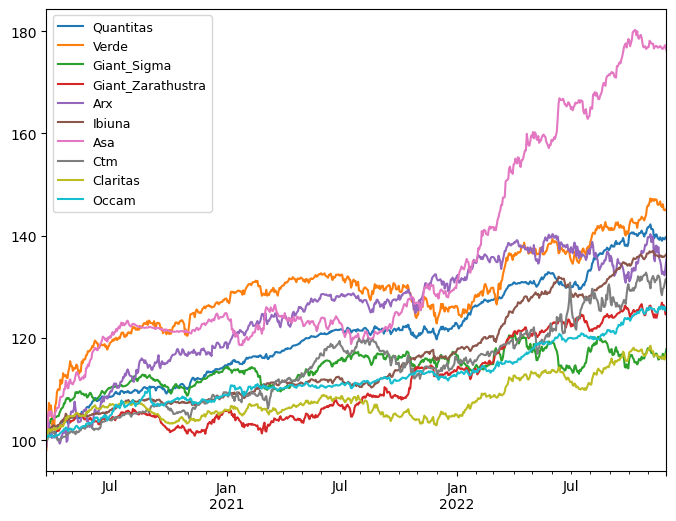

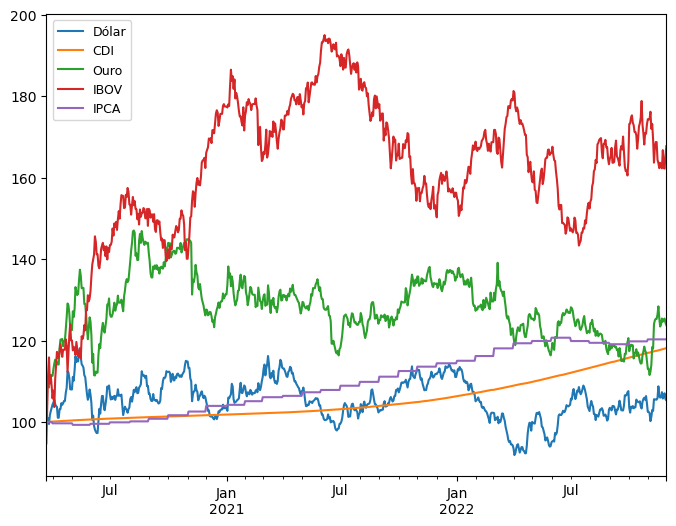

In [5]:
# Criação das Séries Temporais dos Fundos

base_100 = base_import.copy()

for i in base_100.keys():
    ls = []
    a = 100
    for j in base_100.index:
        a = a*( 1 + base_100[i][j] )
        ls.append(a)
    base_100[i] = ls

base_indices = base_100[base_100.keys()[0:5]]
base_fundos = base_100[base_100.keys()[5:]]

base_fundos.plot(figsize=(8,6))
plt.legend(fontsize=9)
base_indices.plot(figsize=(8,6))
plt.legend(fontsize=9)

## Correlação entre os índices e correlação entre os fundos e índices

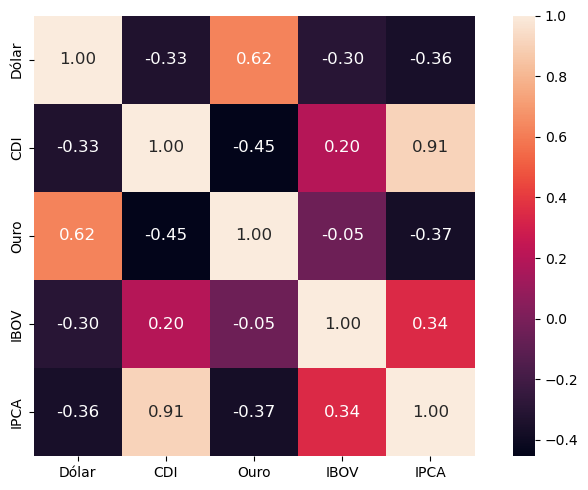

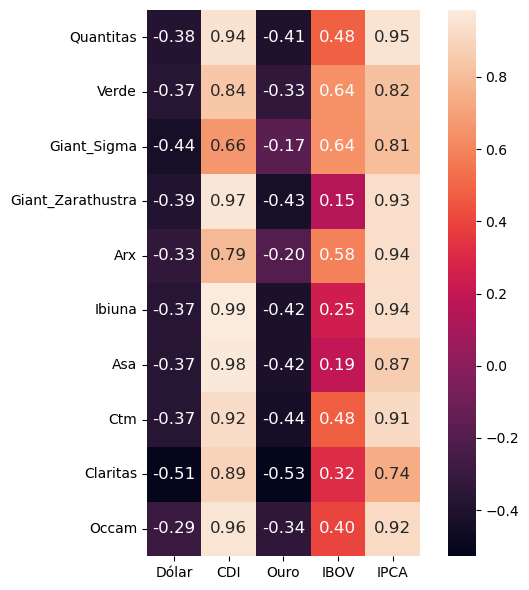

Correlação entre o fundo ASA e as variáveis Macro Econômicas a partir de 03/01/2022:
Dólar   -0.02
CDI      0.95
Ouro    -0.79
IBOV     0.01
IPCA     0.84
Name: Asa, dtype: float64


In [6]:
corr_ind = base_100[base_100.keys()[0:5]].corr()

plt.figure(figsize=(8, 5))

cols= [i for i in corr_ind.keys()]
sns.heatmap(
            corr_ind,
            cbar=True,
            annot=True,
            square=True,
            fmt='.2f',
            annot_kws={'size': 12},
            yticklabels=cols,
            xticklabels=cols)
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 6))

corr_fund_x_ind = base_100.corr()[base_100.keys()[0:5]][5:]

cols= [i for i in corr_fund_x_ind.keys()]
lins= [i for i in corr_fund_x_ind.index]

sns.heatmap(corr_fund_x_ind,
            cbar=True,
            annot=True,
            square=True,
            fmt='.2f',
            annot_kws={'size': 12},
            yticklabels=lins,
            xticklabels=cols)
plt.tight_layout()
plt.show()

print("Correlação entre o fundo ASA e as variáveis Macro Econômicas a partir de 03/01/2022:")
print(round(base_100[base_100.index >= '01/01/2022'].corr()[base_100.keys()[11]][0:5],2))


### Criação das funções dos modelos de predição

In [7]:
def model_sarima(base, teste):

    # Utilização o processo auto_arima para encontrar o melhor modelo ajustado a base de treino 

    treino_teste = teste
    base_fundos_ST_treino = base.iloc[:int(base.shape[0]*treino_teste)]
    base_fundos_ST_teste = base.iloc[int(base.shape[0]*treino_teste):]

    stepwise_fit = auto_arima(base_fundos_ST_treino,start_p=0, start_q=0,
                              max_p=5, max_q=5, m=5,
                              seasonal=True,
                              error_action='ignore',   
                              suppress_warnings=True,  
                              stepwise=True)           

    # Ajustando o modelo SARIMA para a base de treino 
    modelo = SARIMAX(base_fundos_ST_treino, order=stepwise_fit.order,seasonal_order=stepwise_fit.seasonal_order)
    resultado = modelo.fit()
    resultado.summary()

    # Previsão utilizando o modelo SARIMA
    inicio = len(base_fundos_ST_treino)
    fim = len(base_fundos_ST_treino) + len(base_fundos_ST_teste) - 1
    predito_SARIMA = resultado.predict(start=inicio, end=fim, dynamic=False).rename('Previsões SARIMA')

    return predito_SARIMA

In [8]:
def model_holt(base, teste):

    warnings.filterwarnings("ignore")
    
    treino_teste = teste
    base_fundos_ST_treino = base.iloc[:int(base.shape[0]*treino_teste)]
    base_fundos_ST_teste = base.iloc[int(base.shape[0]*treino_teste):]

    # Ajuste do modelo de Holt Winters
    def_conf_HW = ExponentialSmoothing(base_fundos_ST_treino,trend='add',seasonal='mul',seasonal_periods=7).fit()

    # Previsão utilizando o modelo de Holt Winters
    predito_HW = def_conf_HW.forecast(base_fundos_ST_teste.shape[0]).rename('Previsão Holt-Winters')
    
    return predito_HW

In [9]:
def model_theta(base, teste):
    
    treino_teste = teste
    base_fundos_ST_treino = base.iloc[:int(base.shape[0]*treino_teste)]
    base_fundos_ST_teste = base.iloc[int(base.shape[0]*treino_teste):]
    
    # Ajustando o modelo Theta model para a base de treino 
    res = ThetaModel(base_fundos_ST_treino).fit()

    # Previsão utilizando o modelo Theta model
    predito_TM = res.forecast(base_fundos_ST_teste.shape[0]).rename('Previsões Theta Model')
  
    return predito_TM

In [10]:
def model_lstm(base, teste):

    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)

    treino_teste = teste
    base_fundos_ST_treino = base.iloc[:int(base.shape[0]*treino_teste)]
    base_fundos_ST_teste = base.iloc[int(base.shape[0]*treino_teste):]

    # Padronização dos dados em escla de 0 a 1
    scaler = MinMaxScaler()
    scaler.fit(pd.DataFrame(base_fundos_ST_treino))

    scaled_train = scaler.transform(pd.DataFrame(base_fundos_ST_treino))
    scaled_test = scaler.transform(pd.DataFrame(base_fundos_ST_teste))

    batch_s = 1
    
    mm = 0
    melhor_modelo = pd.Series([])
    predito_LSTM = pd.DataFrame(base_fundos_ST_teste)

    for i in range(4):
        
        mm += 1
          
        # definindo o gerador
        n_input = 7 
        n_features = 1
        generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size= batch_s)

        model = Sequential()

        model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
        
        if i < 3:
            model.add(Dense(1))
        else:
            model.add(Dense(1, activation='softmax'))
            if i == 4:
                batch_s = 16                

        # Compile as camadas
        model.compile(loss='mse', optimizer='SGD')

        model.fit(generator, epochs=10, verbose = False)

        model.history.history.keys()
        loss_per_epoch = model.history.history['loss']

        test_predictions = []

        first_eval_batch = scaled_train[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))

        for i in range(len(base_fundos_ST_teste)):

            current_pred = model.predict(current_batch)[0]

            # predição
            test_predictions.append(current_pred) 

            # atualize a rodada para agora incluir a previsão e descartar o primeiro valor
            current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


        # revertendo a normalização para os dados de confirmação
        true_predictions = scaler.inverse_transform(test_predictions)   
        # predito_LSTM['Previsões LSTM'] = true_predictions
        predito_LSTM[mm] = true_predictions

        melhor_modelo[mm] = round(mean_absolute_error(base_fundos_ST_teste, predito_LSTM[mm]),2)
        
    melhor_modelo = melhor_modelo[melhor_modelo == melhor_modelo.min()].index[0]
        
    return predito_LSTM[melhor_modelo], melhor_modelo

In [11]:
def model_reg(base, teste):

    treino_teste = teste
    obs_xy_reg = pd.DataFrame([])
    reg_pol = pd.DataFrame([])
    melhor_grau = pd.Series([])
    mg = 0
    
    base_fundos_ST_teste = base.iloc[int(base.shape[0]*treino_teste):]

    for i in range(1,10):

        grau = i
        mg += 1

        transf = PolynomialFeatures(degree = grau, include_bias=False)
        transf.fit(np.array(range(int(base.shape[0]*treino_teste))).reshape((-1,1)))

        y = np.array(base.iloc[ : int(base.shape[0]*treino_teste)])
        x_ = transf.transform(np.array(range(int(base.shape[0]*treino_teste))).reshape((-1,1)))

        model1 = LinearRegression().fit(x_, y)
        y_obs = model1.predict(x_)
        obs_y = pd.DataFrame(y_obs)
        obs_x = pd.DataFrame(np.array(base.iloc[:int(base.shape[0]*treino_teste)].index).reshape((-1,1)))
        obs_xy = pd.concat([obs_x, obs_y], axis=1)
        obs_xy.columns = ['', c]
        obs_xy = obs_xy.set_index('')

        transf1 = PolynomialFeatures(degree = grau, include_bias=False)
        transf1.fit(np.array(range(int(base.shape[0]*treino_teste), base.shape[0])).reshape((-1,1)))
        x_pred = transf.transform(np.array(range(int(base.shape[0]*treino_teste), base.shape[0])).reshape((-1,1)))

        y_pred = model1.predict(x_pred)

        pred_y = pd.DataFrame(y_pred)
        pred_x = pd.DataFrame(np.array(base.iloc[int(base.shape[0]*treino_teste):].index).reshape((-1,1)))
        pred_xy = pd.concat([pred_x, pred_y], axis=1)
        pred_xy.columns = ['', c]
        pred_xy = pred_xy.set_index('')

        reg_pol[mg] = pred_xy
        obs_xy_reg[mg] = obs_xy

        melhor_grau[mg] = round(mean_absolute_error(base_fundos_ST_teste, pred_xy[c]),2)


    melhor_grau = melhor_grau[melhor_grau == melhor_grau.min()].index[0]
   
    return obs_xy_reg[melhor_grau], reg_pol[melhor_grau], melhor_grau

## Execução dos modelos de predição

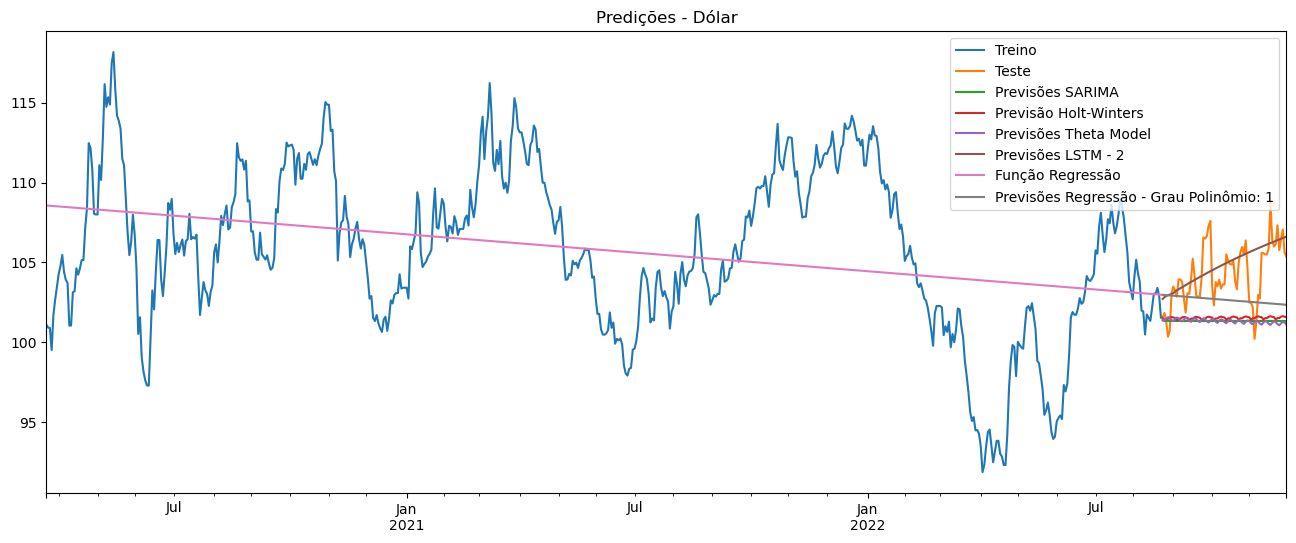

MAE SARIMA:        2.99
MAE Holt-Winters:  2.82
MAE Theta Model:   3.02
MAE LSTM:          1.22 - 2
MAE Regressão:     2.0 - Grau Polinômio: 1


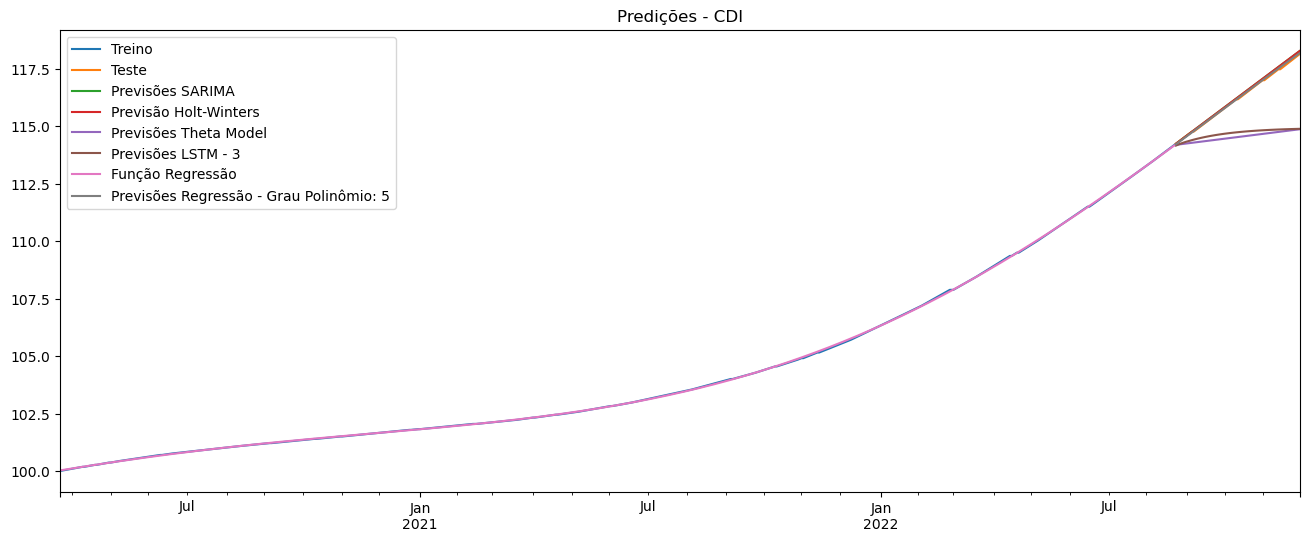

MAE SARIMA:        0.07
MAE Holt-Winters:  0.07
MAE Theta Model:   1.66
MAE LSTM:          1.51 - 3
MAE Regressão:     0.03 - Grau Polinômio: 5


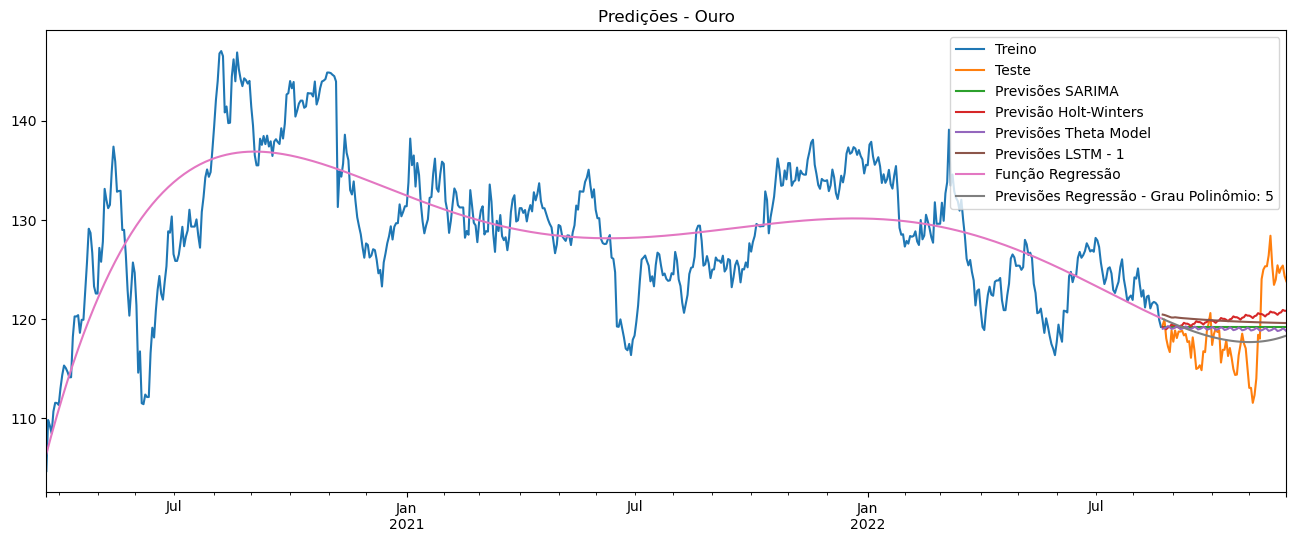

MAE SARIMA:        3.05
MAE Holt-Winters:  3.18
MAE Theta Model:   3.01
MAE LSTM:          3.47 - 1
MAE Regressão:     2.87 - Grau Polinômio: 5


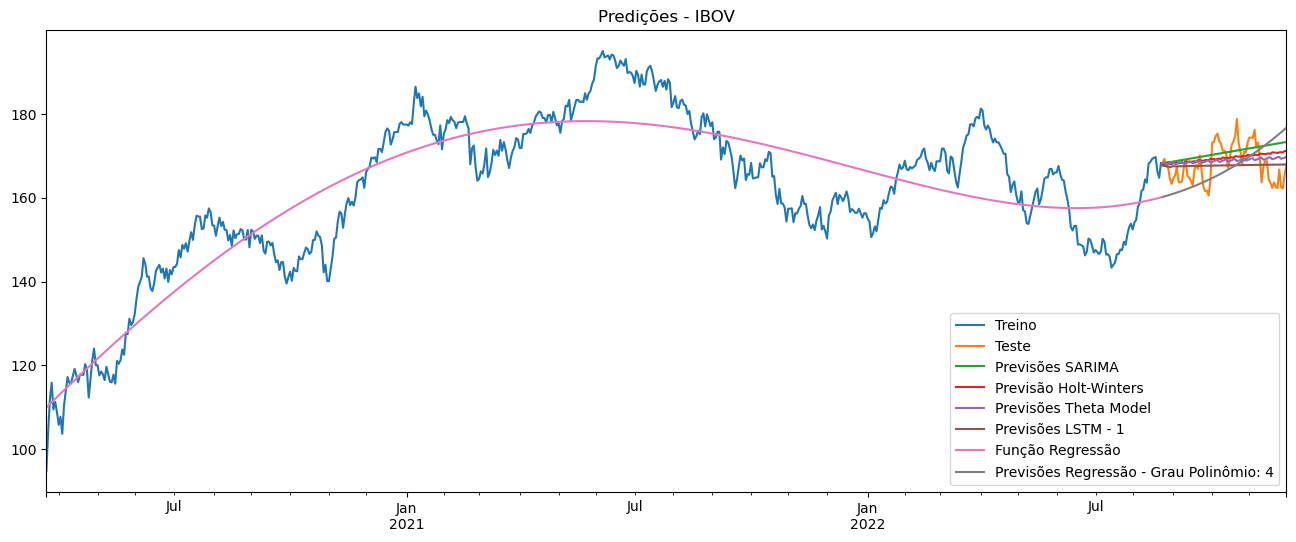

MAE SARIMA:        4.16
MAE Holt-Winters:  3.84
MAE Theta Model:   3.75
MAE LSTM:          3.66 - 1
MAE Regressão:     5.47 - Grau Polinômio: 4


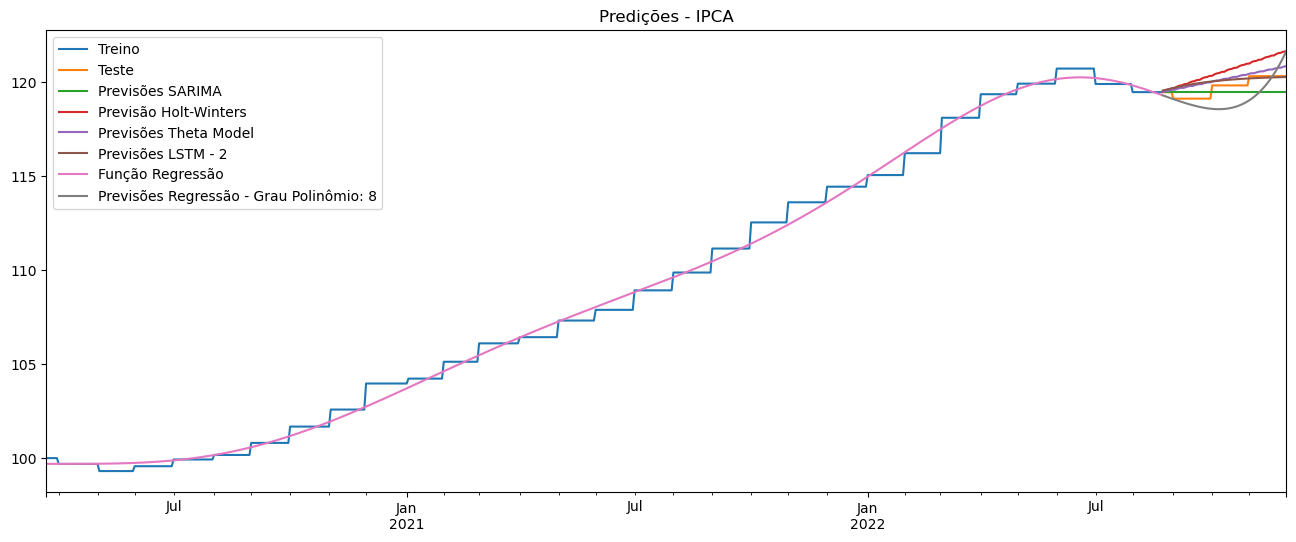

MAE SARIMA:        0.48
MAE Holt-Winters:  0.85
MAE Theta Model:   0.43
MAE LSTM:          0.36 - 2
MAE Regressão:     0.68 - Grau Polinômio: 8


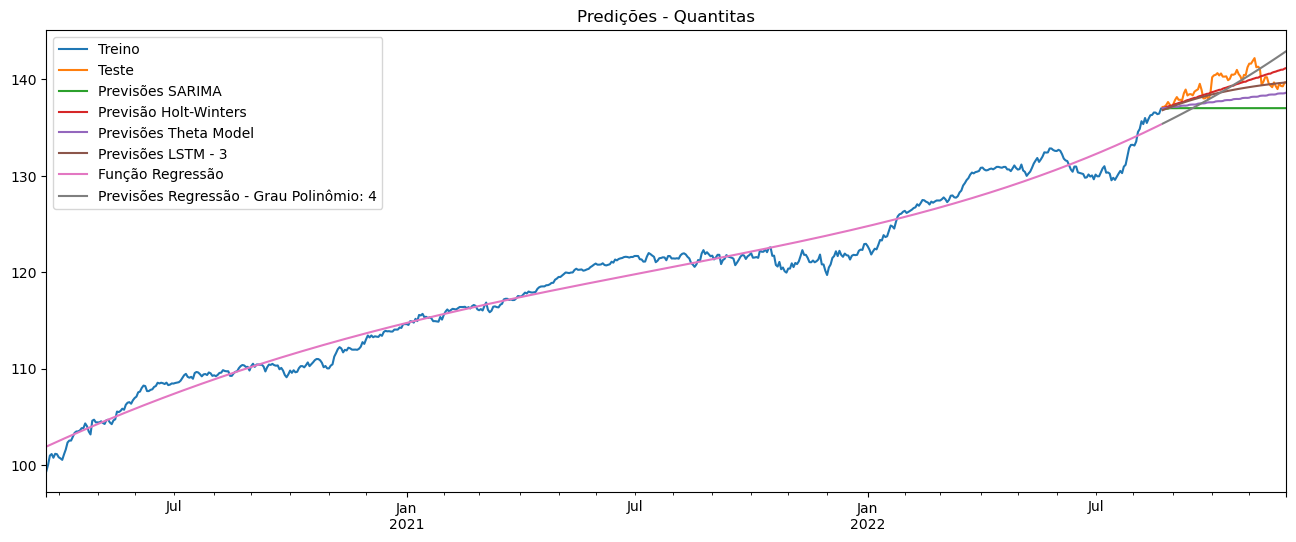

MAE SARIMA:        2.44
MAE Holt-Winters:  0.93
MAE Theta Model:   1.65
MAE LSTM:          0.97 - 3
MAE Regressão:     1.55 - Grau Polinômio: 4


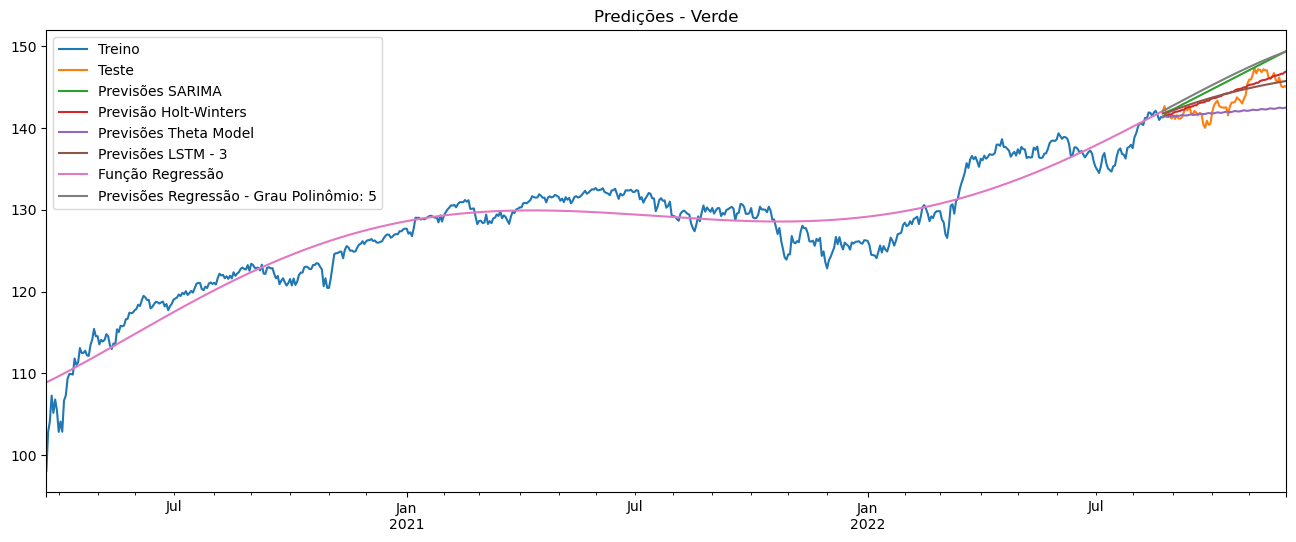

MAE SARIMA:        2.12
MAE Holt-Winters:  1.12
MAE Theta Model:   1.77
MAE LSTM:          1.25 - 3
MAE Regressão:     2.48 - Grau Polinômio: 5


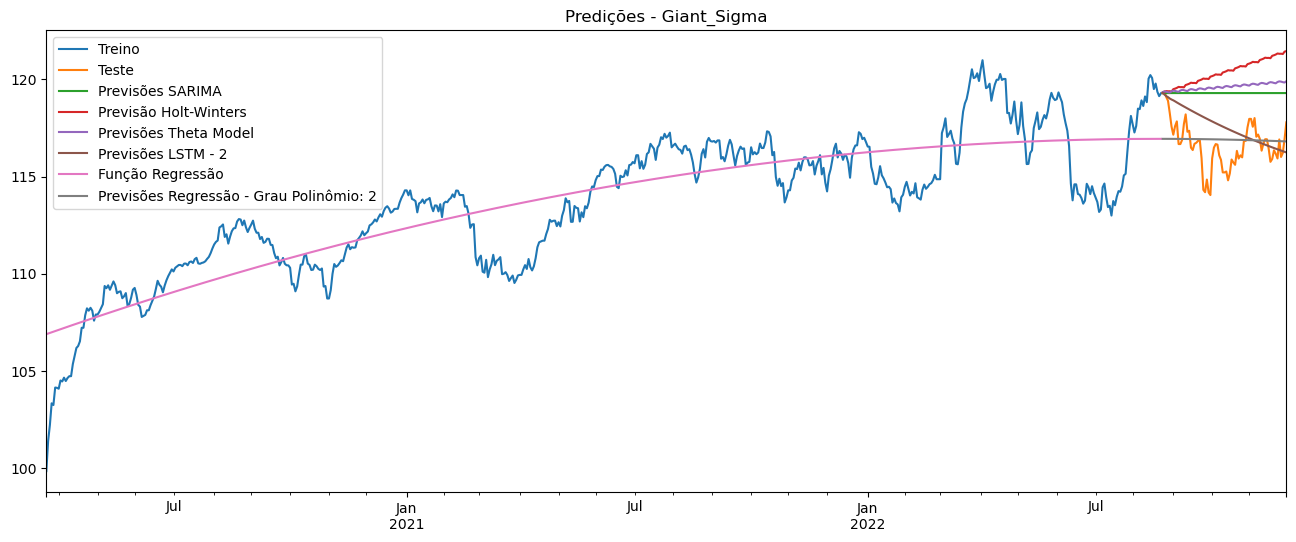

MAE SARIMA:        2.69
MAE Holt-Winters:  3.76
MAE Theta Model:   3.0
MAE LSTM:          1.24 - 2
MAE Regressão:     0.9 - Grau Polinômio: 2


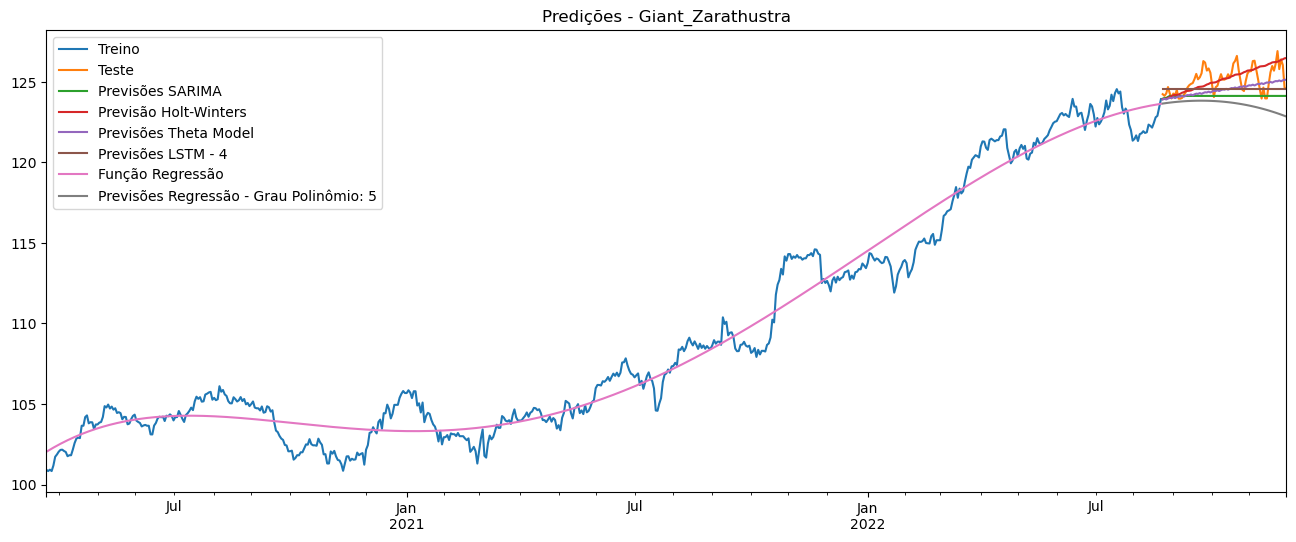

MAE SARIMA:        1.02
MAE Holt-Winters:  0.58
MAE Theta Model:   0.76
MAE LSTM:          0.77 - 4
MAE Regressão:     1.53 - Grau Polinômio: 5


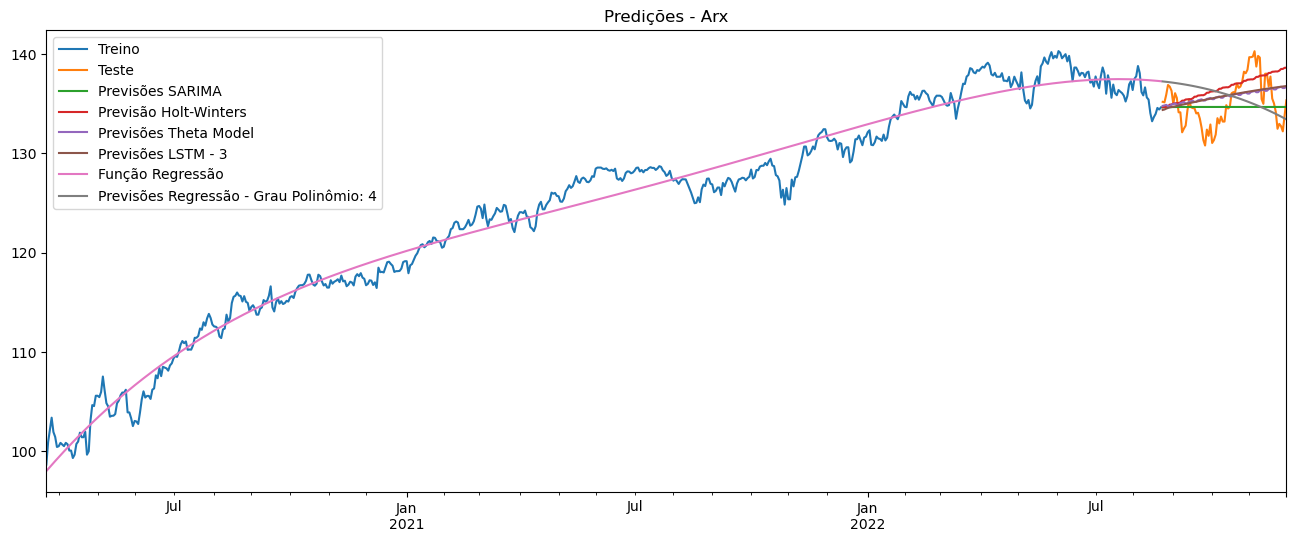

MAE SARIMA:        1.95
MAE Holt-Winters:  2.24
MAE Theta Model:   1.99
MAE LSTM:          2.0 - 3
MAE Regressão:     2.56 - Grau Polinômio: 4


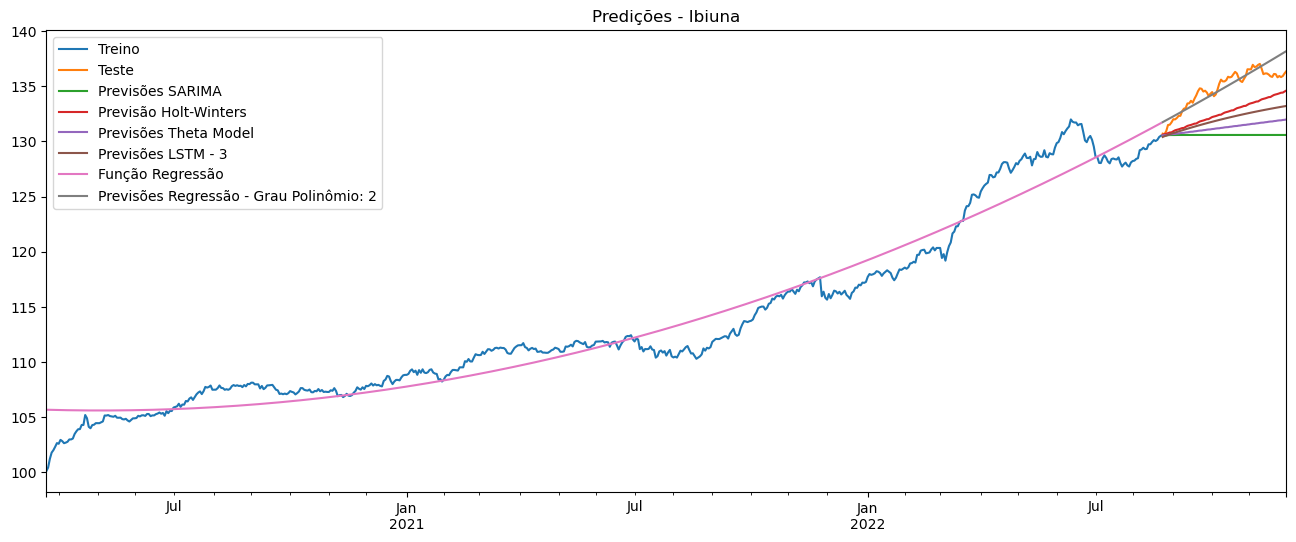

MAE SARIMA:        4.19
MAE Holt-Winters:  2.19
MAE Theta Model:   3.51
MAE LSTM:          2.79 - 3
MAE Regressão:     0.69 - Grau Polinômio: 2


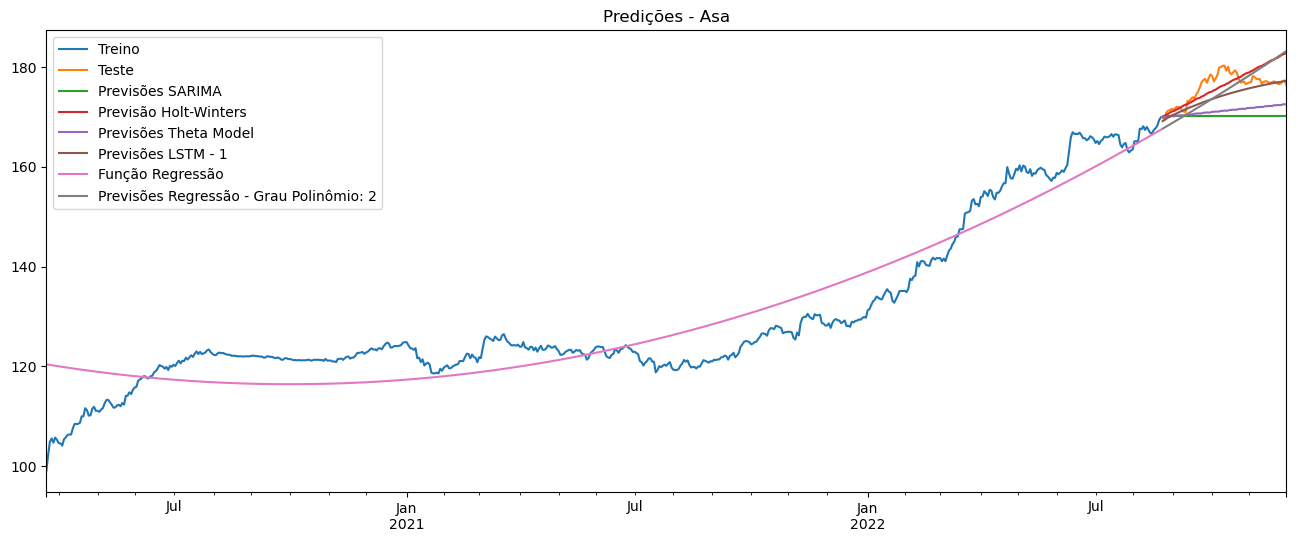

MAE SARIMA:        5.88
MAE Holt-Winters:  2.31
MAE Theta Model:   4.81
MAE LSTM:          2.11 - 1
MAE Regressão:     3.14 - Grau Polinômio: 2


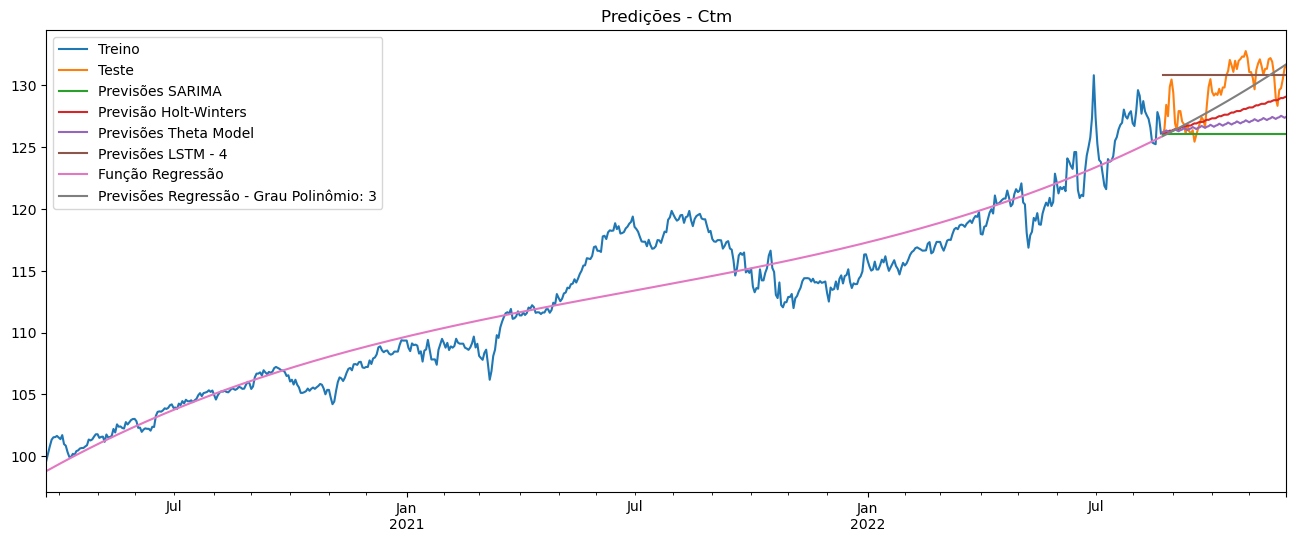

MAE SARIMA:        3.46
MAE Holt-Winters:  2.12
MAE Theta Model:   2.78
MAE LSTM:          1.94 - 4
MAE Regressão:     1.44 - Grau Polinômio: 3


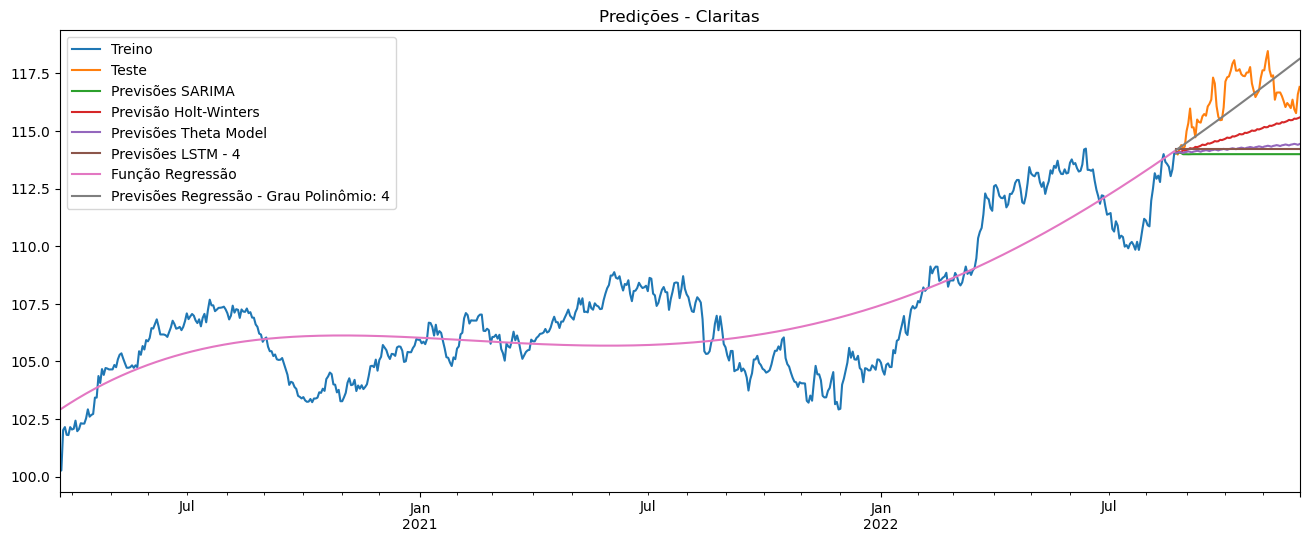

MAE SARIMA:        2.42
MAE Holt-Winters:  1.6
MAE Theta Model:   2.17
MAE LSTM:          2.19 - 4
MAE Regressão:     0.91 - Grau Polinômio: 4


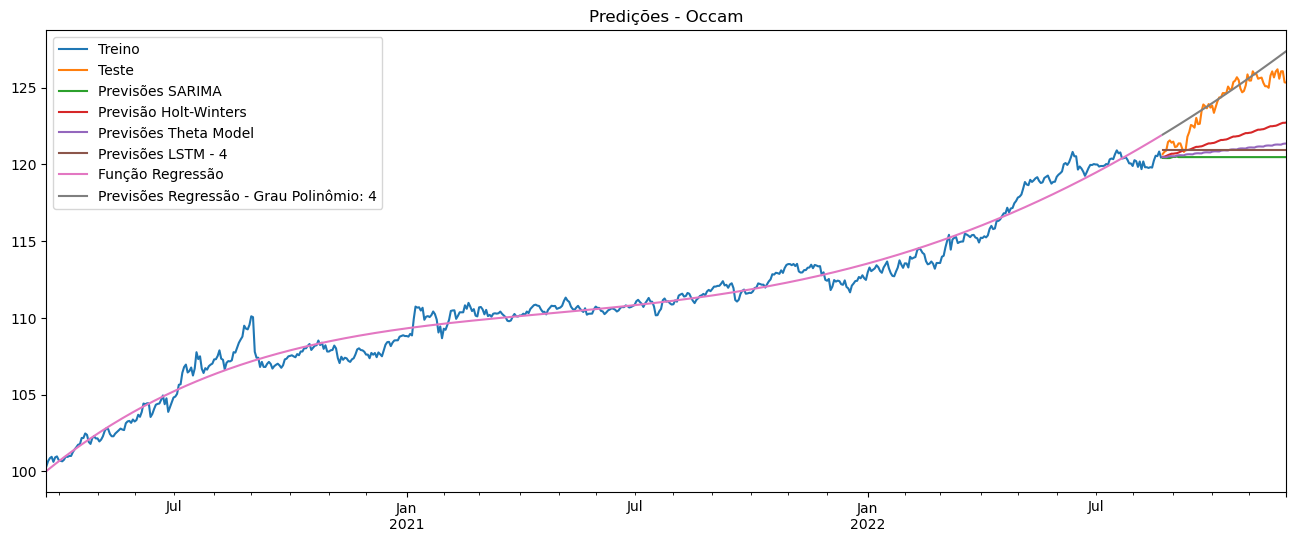

MAE SARIMA:        3.51
MAE Holt-Winters:  2.36
MAE Theta Model:   3.07
MAE LSTM:          3.08 - 4
MAE Regressão:     0.7 - Grau Polinômio: 4

Tempo de execução: 46 minutos e 37 segundos


In [12]:
start_time = time.time()

tbl_resumo_mae = pd.DataFrame({0:[0,1,2,3,4]}).set_index(pd.Index(
    ['MAE_SARIMA', 'MAE_Holt_Winters', 'MAE_Theta_Model', 'MAE_LSTM', 'MAE_Regressao']))
tbl_resumo_mae = tbl_resumo_mae.drop(0, axis=1)

for c in base_100.keys():

    treino_teste = 0.90

    base_100_fil = base_100[c]
    base_fundos_ST_treino = base_100_fil.iloc[:int(base_100.shape[0]*treino_teste)]
    base_fundos_ST_teste = base_100_fil.iloc[int(base_100.shape[0]*treino_teste):]
    
    predito_SARIMA = base_100_fil.pipe(model_sarima, treino_teste)
    predito_HW = base_100_fil.pipe(model_holt, treino_teste)
    predito_TM = base_100_fil.pipe(model_theta, treino_teste)
    predito_LSTM, melhor_modelo = base_100_fil.pipe(model_lstm, treino_teste)
    func_rec, predito_reg, melhor_grau = base_100_fil.pipe(model_reg, treino_teste)

    fig, ax = plt.subplots()
    plt.title(f'Predições - {c}')
    base_fundos_ST_treino.plot(legend=True,label='Treino')
    base_fundos_ST_teste.plot(legend=True,label='Teste',figsize=(16,6))
    predito_SARIMA.plot(legend=True,label='Previsões SARIMA');
    predito_HW.plot(legend=True,label='Previsão Holt-Winters');
    predito_TM.plot(legend=True,label='Previsões Theta Model');
    predito_LSTM.plot(legend=True,label=f'Previsões LSTM - {melhor_modelo}');
    func_rec.plot(legend=True,label='Função Regressão');
    predito_reg.plot(legend=True,label= f'Previsões Regressão - Grau Polinômio: {melhor_grau}');

    plt.show()

    MAE_SARIMA = round(mean_absolute_error(base_fundos_ST_teste , predito_SARIMA),2)
    MAE_Holt_Winters = round(mean_absolute_error(base_fundos_ST_teste , predito_HW),2)
    MAE_Theta_Model = round(mean_absolute_error(base_fundos_ST_teste , predito_TM),2)
    MAE_LSTM = round(mean_absolute_error(base_fundos_ST_teste , predito_LSTM),2)
    MAE_Regressao = round(mean_absolute_error(base_fundos_ST_teste , predito_reg),2)
    
    tbl_resumo_mae[c] = [MAE_SARIMA, MAE_Holt_Winters, MAE_Theta_Model, MAE_LSTM, MAE_Regressao]
        
    print(f'MAE SARIMA:       ', MAE_SARIMA)
    print(f'MAE Holt-Winters: ', MAE_Holt_Winters)
    print(f'MAE Theta Model:  ', MAE_Theta_Model)
    print(f'MAE LSTM:         ', MAE_LSTM, '-', melhor_modelo)
    print(f'MAE Regressão:    ', MAE_Regressao, '- Grau Polinômio:', melhor_grau)
    
tbl_resumo_mae.to_excel('Tabela MAE.xlsx')
    
end_time = time.time()
print("\nTempo de execução:", math.floor((end_time - start_time)/60), "minutos e", 
      math.ceil(((end_time - start_time)/60 - math.floor((end_time - start_time)/60))*60), "segundos")